In [1]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, Plots, CSV, DataFrames, JLD2, CairoMakie
import Base: diff

# Trogdon Code
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n # array from -L to L leaving out L

F = c -> -1 .* mfft(mifft(D*c) .* integrate(c) .+ mifft(c).^2)

#13 (generic function with 1 method)

In [2]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end 

In [3]:
function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A(p)
        a = (r'*r)/(p'*q)
        x += a*p
        r_old = r
        r += - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    x
end

CG (generic function with 1 method)

In [4]:
function rk4(a, Mats, dt) 
    D3_dt = Mats[1]
    D3_3dt2 = Mats[2]
    D3_2dt = Mats[3]
    iD3_dt = Mats[4]
    iD3_3dt2 = Mats[5]
    iD3_2dt = Mats[6]
    f1 = D3_dt * F(iD3_dt * a)
    f2 = D3_3dt2 * F(iD3_3dt2 * (a+(dt/2)*f1))
    f3 = D3_3dt2 * F(iD3_3dt2 * (a+(dt/2)*f2))
    f4 = D3_2dt * F(iD3_2dt * (a+dt*f3))
    a = a + (dt/6)*(f1+2*f2+2*f3+f4)
    return a
end

rk4 (generic function with 1 method)

In [5]:
# input: vector c of Fourier coefficients of a function
# variables defined outside of function: L,c_,n,X,m,iD
# output: vector q of function values of the antiderivative of the function
function integrate(c)
    ind = findfirst(n .== 0)
    S = iD*c
    q = c[ind]/m .* (X .+ L) + mifft(S)
    q = q .- q[1] .+ c_
    return q
end

integrate (generic function with 1 method)

## Undamped

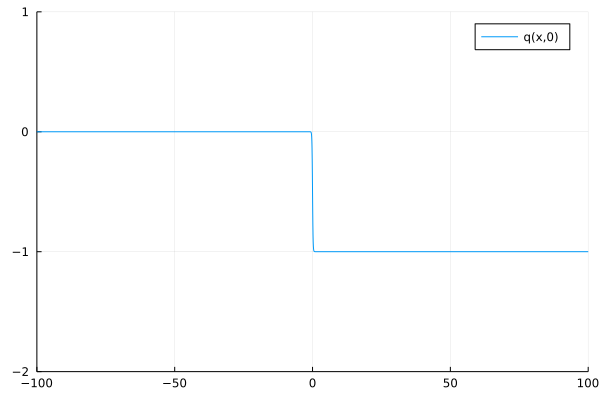

In [19]:
L = 1000
m = 2^15
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)
ind = findfirst(n .== 0)
iD = copy(D)
iD[ind,ind] = 1.0
iD = inv(iD)
iD[ind,ind] = 0.0

# initial condition
func = x -> (1 .+ exp.(10*x)).^(-1) .- 1
f = func(X)
c_ = f[1]
plot(X,f, xaxis = [-100,100], yaxis = [-2,1], label = "q(x,0)")

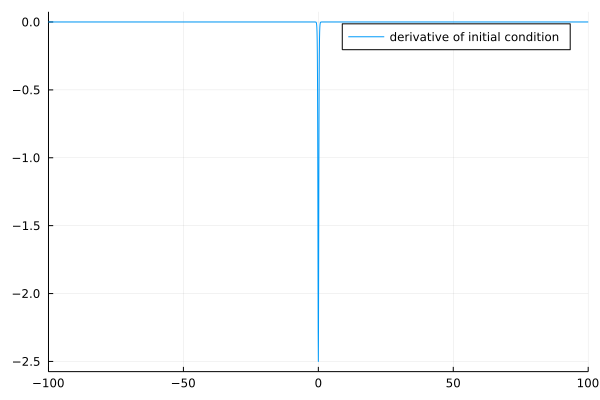

In [20]:
# derivative of initial condition
df = X ->  X > 40 ? 0.0 : -(10 * exp.(10 .* X)) ./ (1 .+ exp.(10 .* X)).^2
#f_prime = -(10 * exp.(10 .* X)) ./ (1 .+ exp.(10 .* X)).^2
f_prime = map(df,X)
plot(X,f_prime, label = "derivative of initial condition", xaxis = [-100,100])

573.238615 seconds (19.39 M allocations: 1.329 TiB, 8.23% gc time)


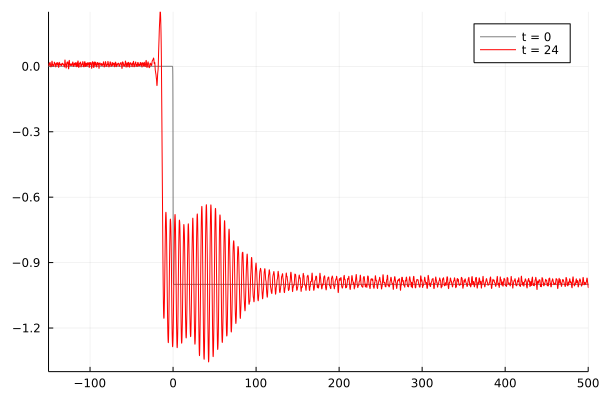

In [21]:
c = mfft(f_prime)
dt = 0.001
T = 24
t = 0.0
fr = 100 #frames/unit time
steps = convert(Int64,ceil(T/dt))

D3_dt = exp((D.^3 + D.^5) * 0)
D3_3dt2 = exp((D.^3 + D.^5) * (dt/2))
D3_2dt = exp((D.^3 + D.^5) * (dt))
iD3_dt = exp(-(D.^3 + D.^5) * 0)
iD3_3dt2 = exp(-(D.^3 + D.^5) * (dt/2))
iD3_2dt = exp(-(D.^3 + D.^5) * (dt))
Mats = [D3_dt,D3_3dt2,D3_2dt,iD3_dt,iD3_3dt2,iD3_2dt]

y_low = -1.4
y_up = 0.25
x_low = -150
x_up = 500

@time begin
    
for i = 1:steps
    a = rk4(c,Mats,dt)
    c = Mats[6] * a    
    t += dt
end
    
end

plot(X, f, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 0", line = :grey)
plot!(X, integrate(c) |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 24", line = :red)

In [208]:
# CairoMakie plot
size_inches = (8.5, 3)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12)
ax = Axis(fig[1,1])
ax.xlabel = "Undamped Solution"
lines!(ax, X[14747:21301], f[14747:21301], label = "q(x,0)", color = :grey)
lines!(ax, X[14747:21301], undampedPlotVals[14747:21301], label = "q(x,24)", aspect_ratio = 90, color = :red)
axislegend()
fig
save("kawaundamped.pdf", fig, pt_per_unit = 1)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x00000000d32dddf0, 612.0, 216.0, IOContext(IOStream(<file C:\Users\annie\Dropbox\ArtificialBoundaryConditions\data\kawaundamped.pdf>)))


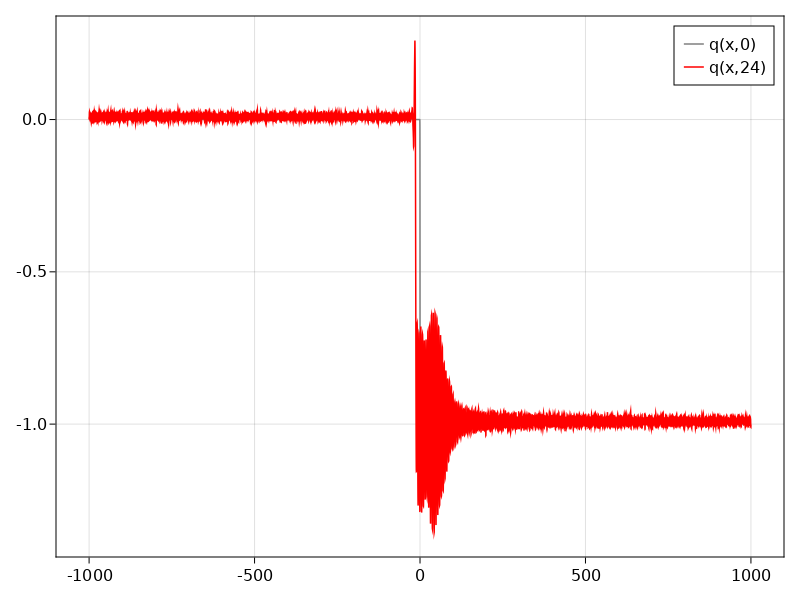

In [172]:
current_figure()

In [81]:
undampedPlotVals = integrate(c) |> real;
undampedC = c;

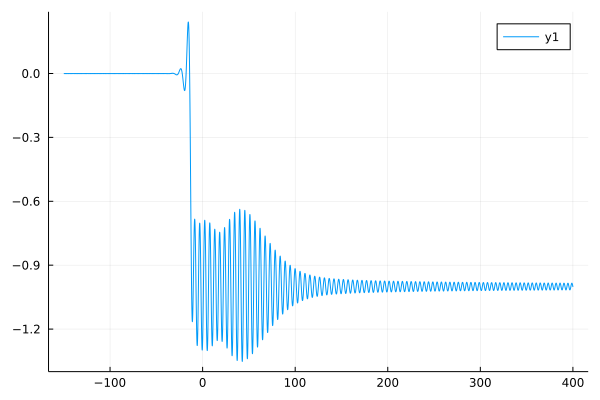

In [132]:
m = 2^22
L = 10^5
X = mgrid(m,L)
if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)
ind = findfirst(n .== 0)
iD = copy(D)
iD[ind,ind] = 1.0
iD = inv(iD)
iD[ind,ind] = 0.0
trueVals = integrate(data) |> real
plot(X[2094008:2105542],trueVals[2094008:2105542])

In [133]:
fm = trig_interp(1000,c) # IMPORTANT: change this value for different L
new_df = map(fm,X)
c_new = mfft(new_df);

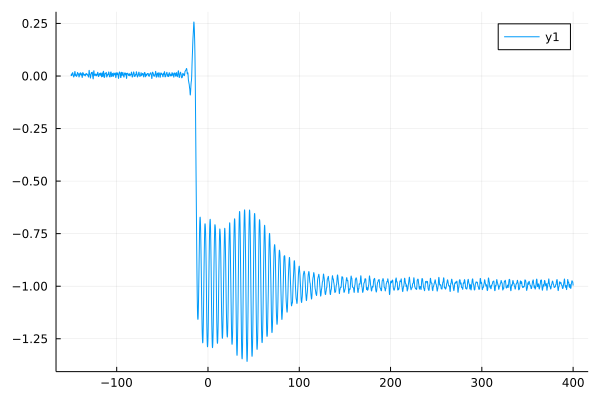

In [134]:
ind = findfirst(n .== 0)
S = iD*c_new;
q = c_new[ind]/m .* (X .+ L) + mifft(S);
q = q .- q[2094008] .+ c_;
# check that interpolation worked:
plot(X[2094008:2105542],q[2094008:2105542] |> real)

In [135]:
undampedVals = q[2094008:2105542]
trueVals = trueVals[2094008:2105542] # get the function values between approx -150 and 400
error = maximum(abs.(undampedVals.-trueVals))

0.027231732343260165

In [91]:
y_up = 0.3
x_up = 200
plot(mgrid(2^15,1000), f, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "q(x,0)", line = :lightgrey)
plot!(X[1047005:1052769], undampedVals |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "Undamped Solution", line = :red)
plot!(X[1047005:1052769], myVals |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "Damped Solution", line = :black)
#savefig("kawacompare")

In [97]:
x_low = -130
plot(mgrid(2^15,1000), f, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "q(x,0)", line = :grey)
plot!(X[1047005:1052769], undampedVals |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "q(x,24)", line = :red)
savefig("kawaundamped")

In [98]:
plot(mgrid(2^15,1000), f, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "q(x,0)", line = :grey)
plot!(X[1047005:1052769], myVals |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "q(x,24)", line = :blue)
savefig("kawadamped")

## Damped

In [32]:
L = 1000
m = 2^15
X = mgrid(m,L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end
D = (pi/L) * Diagonal(1im.*n)
ind = findfirst(n .== 0)
iD = copy(D)
iD[ind,ind] = 1.0
iD = inv(iD)
iD[ind,ind] = 0.0

# initial condition
func = x -> (1 .+ exp.(10*x)).^(-1) .- 1
f = func(X)
c_ = f[1]
plot(X,f, xaxis = [-L,L], yaxis = [-2,1], label = "q(x,0)");

In [33]:
# derivative of initial condition
df = X ->  X > 5 ? 0.0 : -(10 * exp.(10 .* X)) ./ (1 .+ exp.(10 .* X)).^2
#f_prime = -(10 * exp.(10 .* X)) ./ (1 .+ exp.(10 .* X)).^2
f_prime = map(df,X)
plot(X,f_prime, label = "derivative of initial condition", xaxis = [-L,L]);

In [34]:
ℓ1 = -L + (L/2) - 10
ℓ2 = L
σ1 = x -> (1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1)))
# make symmetric:
σ = x -> σ1(x) .+ σ1(-x)
γ = x -> 1 .- σ(-x) # should gamma be skinnier than sigma?

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x))
plot(X,γ(X),label = "γ(x)");
plot!(X,σ(X),label = "σ(x)");

In [35]:
c = mfft(f_prime)
dt = 0.001
T = 25
t = 0.0
fr = 100 #frames/unit time
steps = convert(Int64,ceil(T/dt))

D3_dt = exp((D.^3 + D.^5) * 0)
D3_3dt2 = exp((D.^3 + D.^5) * (dt/2))
D3_2dt = exp((D.^3 + D.^5) * (dt))
iD3_dt = exp(-(D.^3 + D.^5) * 0)
iD3_3dt2 = exp(-(D.^3 + D.^5) * (dt/2))
iD3_2dt = exp(-(D.^3 + D.^5) * (dt))
Mats = [D3_dt,D3_3dt2,D3_2dt,iD3_dt,iD3_3dt2,iD3_2dt]

y_low = -1.2
y_up = 0.5
x_low = -L
x_up = L

@time begin
    
for i = 1:steps 
    a = rk4(c,Mats,dt)
    c = Mats[6] * a    
    t += dt
    
    if isinteger(i / 100)
        func_vals = mifft(c) .* γ(X)
        c = mfft(func_vals)
    end
end
    
end

#plot(X, f, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 0");
#plot!(X, integrate(c) |> real, xaxis = [x_low,x_up], yaxis = [y_low,y_up], label = "t = 25");
# 21 minutes (run again at home with better wifi)
# ERROR = 0.0009

410.281166 seconds (20.33 M allocations: 1.386 TiB, 5.38% gc time, 0.03% compilation time)


In [261]:
# plot in CairoMakie
dampedPlotVals = integrate(c) |> real
size_inches = (8.5, 3)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12)
ax = Axis(fig[1,1])
ax.xlabel = "Damped Solution"
lines!(ax, X[14747:21301], f[14747:21301], label = "q(x,0)", color = :grey)
lines!(ax, X[14747:21301], dampedPlotVals[14747:21301], label = "q(x,24)", aspect_ratio = 90, color = :blue)
axislegend()
fig
save("kawadamped.pdf", fig, pt_per_unit = 1)

LoadError: UndefVarError: ylims! not defined

In [306]:
# plot both damped/undamped on same figure in CairoMakie
size_inches = (11, 5.7)
size_pt = 72 .* size_inches
fig = Figure(resolution = size_pt, fontsize = 12, backgroundcolor = :transparent)
ax1 = Axis(fig[1,1])
ax1.xlabel = "Damped Solution"
lines!(ax1, X[14747:21301], f[14747:21301], label = "q(x,0)", color = :grey)
lines!(ax1, X[14747:21301], dampedPlotVals[14747:21301], label = "q(x,24)", color = :blue)
#axislegend()
ax2 = Axis(fig[2,1])
ax2.xlabel = "Undamped Solution"
lines!(ax2, X[14747:21301], f[14747:21301], label = "q(x,0)", color = :grey)
lines!(ax2, X[14747:21301], undampedPlotVals[14747:21301], label = "q(x,24)", color = :red)
#axislegend()

n1 = length(X[14747:21301])
n2 = length(X[14747:15976])

ax3 = Axis(fig[1,2])
ax3.xlabel = "Damped Oscillations"
lines!(ax3, X[14747:15976], f[14747:15976], label = "q(x,0)", color = :grey)
lines!(ax3, X[14747:15976], dampedPlotVals[14747:15976], label = "q(x,24)", color = :blue)
#axislegend()
ax4 = Axis(fig[2,2])
ax4.xlabel = "Undamped Oscillations"
lines!(ax4, X[14747:15976], f[14747:15976], label = "q(x,0)", color = :grey)
lines!(ax4, X[14747:15976], undampedPlotVals[14747:15976], label = "q(x,24)", color = :red)
#axislegend()
linkaxes!(ax3,ax4)

col1 = fig[1:2, 1] = GridLayout()
col2 = fig[1:2, 2] = GridLayout()

colsize!(col1, 1, 400)
colsize!(col2, 1, Auto())

fig[1, 3] = Legend(fig, ax1)
fig[2, 3] = Legend(fig, ax2)

fig
save("newkawacomparison.pdf", fig, pt_per_unit = 1)

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x00000000d32db6f0, 792.0, 410.0, IOContext(IOStream(<file C:\Users\annie\Dropbox\ArtificialBoundaryConditions\data\newkawacomparison.pdf>)))
